In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from openAIgym.experimenter import *
from openAIgym.data_extractor import *
import gym
import xgboost

from sklearn.multioutput import MultiOutputRegressor
number_of_runs = 10

In [4]:

env = gym.make('LunarLander-v2')
de = DataExtractor(env,get_real_obs_for_luner_lander,RandomLunarAgent())
cache_de = CachingExtractorDecorator(de)

regressor1 = xgboost.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 100)
multi_regressor1 = MultiOutputRegressor(regressor1)
e1 = ExperimenterRunner(multi_regressor1,cache_de)
e1.number_of_runs = number_of_runs

e1.compute_errors()

/home/amir/.local/share/virtualenvs/python-rQ1OrFAJ/lib/python3.9/site-packages/xgboost/data.py:119: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/amir/.local/share/virtualenvs/python-rQ1OrFAJ/lib/python3.9/site-packages/xgboost/data.py:119: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/amir/.local/share/virtualenvs/python-rQ1OrFAJ/lib/python3.9/site-packages/xgboost/data.py:119: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/amir/.local/share/virtualenvs/python-rQ1OrFAJ/lib/python3.9/site-packages/xgboost/data.py:119: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase 

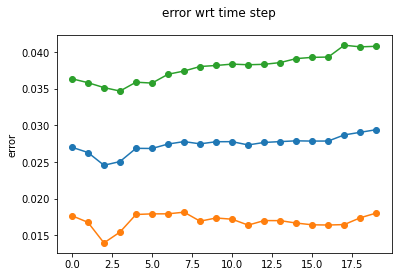

In [8]:
ExperimentPlotter(np.abs).plot_errors_for_state(e1.errors,0,20)

/home/amir/.local/share/virtualenvs/python-rQ1OrFAJ/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/amir/.local/share/virtualenvs/python-rQ1OrFAJ/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


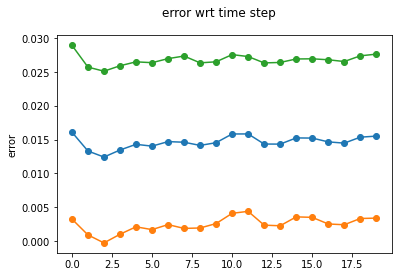

In [9]:
ExperimentPlotter(np.abs).plot_errors_for_state(e1.train_errors,0,20)

In [4]:
regressor2 = xgboost.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 1000)
multi_regressor2 = MultiOutputRegressor(regressor2)
e2 = ExperimenterRunner(multi_regressor2,cache_de)
e2.number_of_runs = number_of_runs

e2.compute_errors()

/home/amir/.local/share/virtualenvs/python-rQ1OrFAJ/lib/python3.9/site-packages/xgboost/data.py:119: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/amir/.local/share/virtualenvs/python-rQ1OrFAJ/lib/python3.9/site-packages/xgboost/data.py:119: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/amir/.local/share/virtualenvs/python-rQ1OrFAJ/lib/python3.9/site-packages/xgboost/data.py:119: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [6]:
ExperimentPlotter(np.abs).plot_errors_for_state(e2.errors,0,30)

/home/amir/.local/share/virtualenvs/python-rQ1OrFAJ/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/amir/.local/share/virtualenvs/python-rQ1OrFAJ/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/home/amir/.local/share/virtualenvs/python-rQ1OrFAJ/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/amir/.local/share/virtualenvs/python-rQ1OrFAJ/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/amir/.local/share/virtualenvs/python-rQ1OrFAJ/lib/python3.9/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, a

IndexError: invalid index to scalar variable.

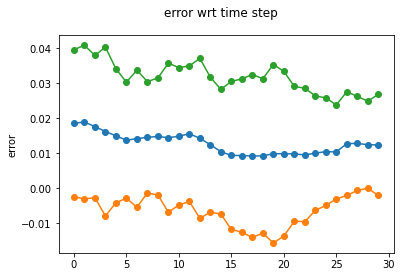

In [6]:
ExperimentPlotter(np.abs).plot_errors_for_state(e2,0,30)

/home/amir/.local/share/virtualenvs/python-rQ1OrFAJ/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/amir/.local/share/virtualenvs/python-rQ1OrFAJ/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


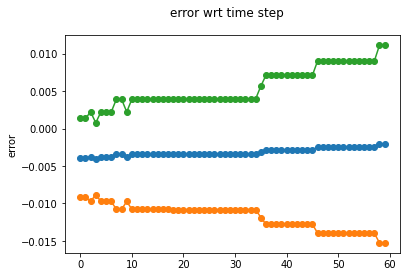

In [9]:
ExperimentPlotter(np.abs).plot_paired_errors_for_state(e1,e2,0,60)

In [19]:
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score, KFold
from keras.models import Sequential
from sklearn.metrics import accuracy_score
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

def baseline_model():
    model = Sequential()
    model.add(Dense(10, input_dim=9, activation='relu'))
    model.add(Dense(8))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
  
nnRegressor = KerasRegressor(build_fn=baseline_model, nb_epoch=100, batch_size=100, verbose=False)

e3 = ExperimenterRunner(nnRegressor,cache_de)
e3.number_of_runs = 10
e3.compute_errors()

In [51]:
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score, KFold
from keras.models import Sequential
from sklearn.metrics import accuracy_score
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

def baseline_model():
    model = Sequential()
    model.add(Dense(40, input_dim=9, activation='relu'))
    model.add(Dense(8))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
  
nnRegressor2 = KerasRegressor(build_fn=baseline_model, nb_epoch=100, batch_size=100, verbose=False)

e4 = ExperimenterRunner(nnRegressor2,cache_de)
e4.number_of_runs = 10
e4.compute_errors()

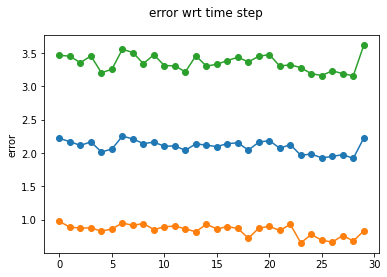

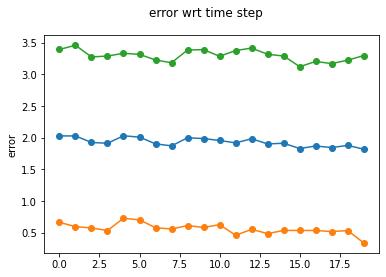

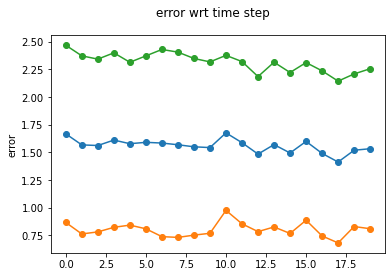

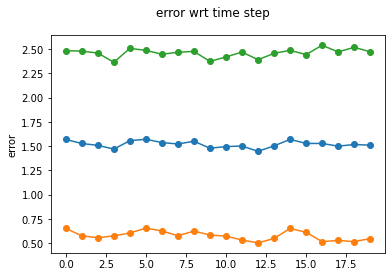

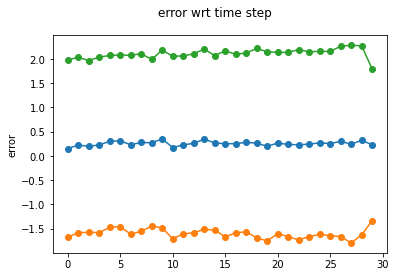

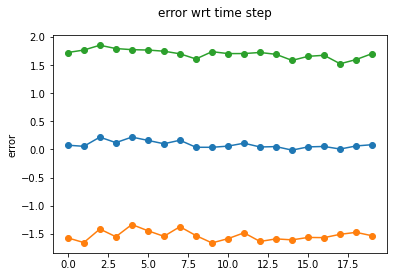

In [53]:
from openAIgym.experimenter import *
state_to_watch = 1
ExperimentPlotter(np.abs).plot_errors_for_state(e3.train_errors,state_to_watch,30)
ep = ExperimentPlotter(np.abs)

ExperimentPlotter(np.abs).plot_errors_for_state(e3.errors,state_to_watch,20)

ExperimentPlotter(np.abs).plot_errors_for_state(e4.train_errors,state_to_watch,20)

ExperimentPlotter(np.abs).plot_errors_for_state(e4.errors,state_to_watch,20)

ExperimentPlotter(np.abs).plot_paired_errors_for_state(e3.train_errors, e4.train_errors, 0, 30)
ExperimentPlotter(np.abs).plot_paired_errors_for_state(e3.errors, e4.errors, 0, 20)

In [61]:
np.mean(np.abs(e3.errors[0]) - np.abs(e4.errors[0]),axis=0)

array([ 2.2198998 , -1.69373703,  1.70620709,  0.2573431 ,  2.84016999,
        1.76568628,  4.90681509,  3.00582026])

[array([[-1.54573309, -4.37125063, -0.60035151, -2.32497048,  1.98060912,
         -0.01266199,  1.60397017,  1.08481431],
        [-2.27613282, -4.60493612, -0.25029042, -1.70418274,  2.41838429,
         -0.07159641,  1.76016307,  1.60596228],
        [-2.306319  , -4.58698177, -0.22040194, -1.6620177 ,  2.4014189 ,
         -0.14407461,  1.76123738,  1.60945964],
        [-1.62273431, -4.30660868, -0.52991956, -2.23899174,  1.92439543,
         -0.23854957,  1.61788678,  1.09650421],
        [-2.10253382, -4.43704367, -0.3810291 , -1.852314  ,  2.22138776,
         -0.12787892,  1.73466468,  1.46278846],
        [-2.08444762, -4.41356611, -0.34797186, -1.60120058,  2.2058053 ,
         -0.1089495 ,  1.70875084,  1.45493436],
        [-1.58963144, -4.2288084 , -0.57699615, -1.77620101,  1.87877366,
         -0.12134668,  1.56632829,  1.0654552 ],
        [-1.61453962, -4.21802902, -0.61407954, -2.20852065,  1.86107649,
         -0.1486766 ,  1.56862187,  1.06557894],
        [-1.6393

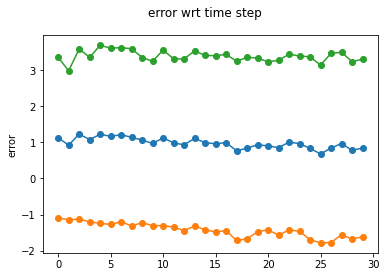

In [81]:
ExperimentPlotter(np.abs).plot_paired_errors_for_state(e3.errors, e4.errors, 0, 30)

In [69]:
ep.get_errors_for_step_n(e4.train_errors,0)

array([[4.94372427e-01, 4.68050569e-01, 7.88352966e-01, 1.30815029e-01,
        4.21264731e+00, 3.84562276e-01, 2.51570821e+00, 8.41688347e+00],
       [2.53801346e+00, 1.00414181e+00, 3.94028246e-01, 1.15356517e+00,
        2.05456384e+00, 6.18348252e-02, 1.07087314e+00, 3.38554716e+00],
       [1.61563897e+00, 1.22461045e+00, 2.64714062e-01, 1.94246888e+00,
        2.57205734e+00, 6.22962601e-04, 1.98687494e+00, 1.87989712e+00]])

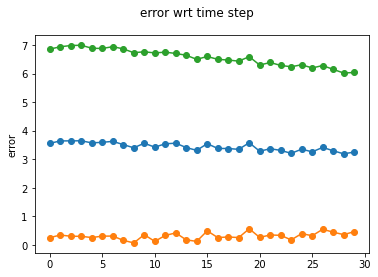

In [66]:
 ExperimentPlotter(np.abs).plot_errors_for_state(e3,5,30)

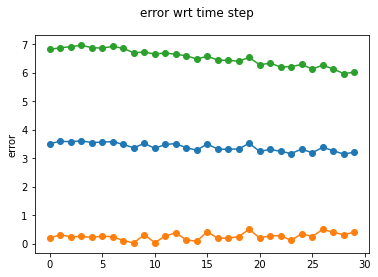

In [57]:
 ExperimentPlotter(np.abs).plot_paired_errors_for_state(e1,e3,5,30)

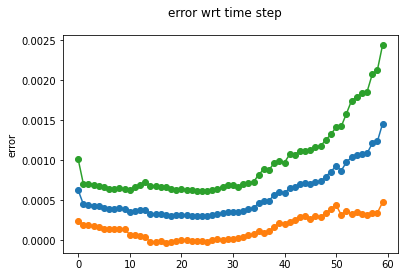

In [6]:
e.plot_errors_for_state(0)

In [4]:

import random
import numpy as np
import xgboost
from sklearn.multioutput import MultiOutputRegressor

from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy
from Box2D import b2Vec2
from openAIgym.data_extractor import *

In [5]:
from openAIgym.data_extractor import DataExtractor, get_real_obs_for_luner_lander, RandomLunarAgent


In [6]:
env = gym.make('LunarLander-v2')
de = DataExtractor(env,get_real_obs_for_luner_lander,RandomLunarAgent())

In [7]:
# def get_test_results_for_seed():
def get_errors_for_seed(i):
  train_dataX, train_dataY = de.get_data(10000+i*50, 20)
  test_dataX, test_dataY = de.get_data(1+i, 1)

  xg_reg = xgboost.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 1000)
  xg_reg = MultiOutputRegressor(xg_reg)
  xg_reg.fit(train_dataX,train_dataY)

  test_pred = xg_reg.predict(test_dataX)
  errors = test_dataY-test_pred
  return errors

errors = []
for i in range (30):
  errors.append(get_errors_for_seed(i))

/home/amir/.local/share/virtualenvs/python-rQ1OrFAJ/lib/python3.9/site-packages/xgboost/data.py:119: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/amir/.local/share/virtualenvs/python-rQ1OrFAJ/lib/python3.9/site-packages/xgboost/data.py:119: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/amir/.local/share/virtualenvs/python-rQ1OrFAJ/lib/python3.9/site-packages/xgboost/data.py:119: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/amir/.local/share/virtualenvs/python-rQ1OrFAJ/lib/python3.9/site-packages/xgboost/data.py:119: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase 

In [13]:
import numpy as np, scipy.stats as st

def conf_interval_for_step(n):
  first_step_errors = [x[n]*x[n] for x in errors if len(x)>n]
  mean=np.mean(first_step_errors,axis=0)
  conf = st.t.interval(0.95, len(first_step_errors)-1, loc=np.mean(first_step_errors,axis=0), scale=st.sem(first_step_errors,axis=0))
  return mean,conf

  

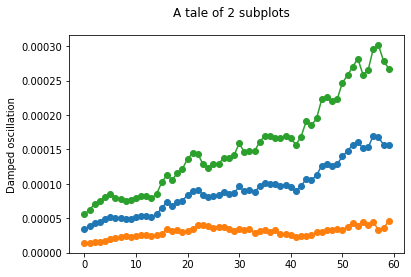

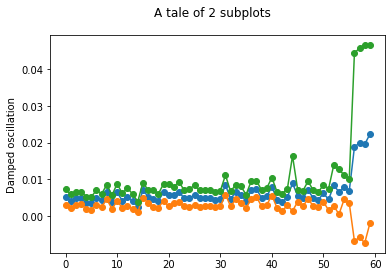

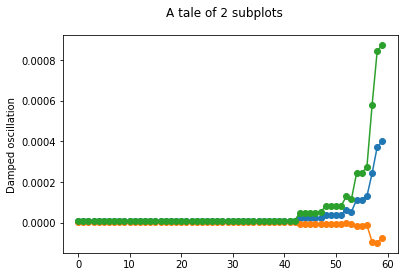

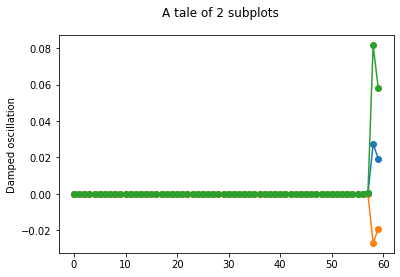

In [22]:
import numpy as np
import matplotlib.pyplot as plt

def plot_errors_for_state(state_idx):
  means = []
  confs = []
  for i in range(60):
    mean, conf = conf_interval_for_step(i)
    means.append(mean)
    confs.append(conf)

  x1 = list(range(len(means)))

  y1 = [x[state_idx] for x in means]
  y2 = [x[0][state_idx] for x in confs]
  y3 = [x[1][state_idx] for x in confs]

  fig, ax1  = plt.subplots(1, 1)
  fig.suptitle('A tale of 2 subplots')

  ax1.plot(x1, y1, 'o-')
  ax1.plot(x1, y2, 'o-')
  ax1.plot(x1, y3, 'o-')
  ax1.set_ylabel('Damped oscillation')

  plt.show()

for i in range(4,8):
  plot_errors_for_state(i)

In [19]:
confidence_interval([x[0] for x in errors_squared])

[array([8.10018538e-05, 6.09360493e-04, 2.40226557e-06, 6.14115934e-03,
        8.81429165e-08, 1.47098841e-06, 8.30461993e-06, 5.76680084e-06]),
 array([1.44409822e-04, 7.09130672e-04, 8.74438121e-04, 4.96467343e-03,
        3.67871036e-06, 8.22103553e-03, 8.30461993e-06, 5.76680084e-06]),
 array([1.27659594e-05, 2.29413937e-05, 3.66069093e-03, 1.21990455e-01,
        4.98019754e-06, 2.83368353e-04, 8.30461993e-06, 5.76680084e-06]),
 array([9.65380870e-04, 1.04495473e-05, 1.23245782e-03, 5.42414069e-03,
        8.32677923e-06, 9.66473172e-03, 8.30461993e-06, 5.76680084e-06]),
 array([4.86442418e-04, 3.61319631e-05, 2.98991229e-03, 1.07506478e-01,
        1.74505589e-06, 2.00617615e-03, 8.30461993e-06, 5.76680084e-06]),
 array([1.25811937e-04, 1.36100157e-05, 1.03687533e-04, 5.98923866e-03,
        4.90249077e-05, 5.13987522e-05, 8.30461993e-06, 5.76680084e-06]),
 array([2.95719956e-04, 2.06614741e-04, 2.46595540e-03, 5.82081952e-03,
        5.66580092e-05, 7.24094164e-03, 8.30461993e-

In [ ]:
# Create environment
env = gym.make('LunarLander-v2')

# Instantiate the agent
model = DQN('MlpPolicy', env, verbose=1)
# Train the agent
model.learn(total_timesteps=int(2e5))
# Save the agent
model.save("dqn_lunar")
del model  # delete trained model to demonstrate loading

# Load the trained agent
model = DQN.load("dqn_lunar", env=env)

# Evaluate the agent
# NOTE: If you use wrappers with your environment that modify rewards,
#       this will be reflected here. To evaluate with original rewards,
#       wrap environment in a "Monitor" wrapper before other wrappers.
mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10)

# Enjoy trained agent
obs = env.reset()
for i in range(100):
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, dones, info = env.step(action)
    env.render()

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 94.8     |
|    ep_rew_mean      | -266     |
|    exploration rate | 0.982    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 2371     |
|    time_elapsed     | 0        |
|    total timesteps  | 379      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 93.1     |
|    ep_rew_mean      | -223     |
|    exploration rate | 0.965    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 2351     |
|    time_elapsed     | 0        |
|    total timesteps  | 745      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 87       |
|    ep_rew_mean      | -183  

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 90.8     |
|    ep_rew_mean      | -191     |
|    exploration rate | 0.603    |
| time/               |          |
|    episodes         | 92       |
|    fps              | 2346     |
|    time_elapsed     | 3        |
|    total timesteps  | 8350     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 90.8     |
|    ep_rew_mean      | -196     |
|    exploration rate | 0.586    |
| time/               |          |
|    episodes         | 96       |
|    fps              | 2344     |
|    time_elapsed     | 3        |
|    total timesteps  | 8720     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 90.5     |
|    ep_rew_mean      | -194     |
|    exploration rate | 0.57     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 90.3     |
|    ep_rew_mean      | -181     |
|    exploration rate | 0.229    |
| time/               |          |
|    episodes         | 180      |
|    fps              | 2352     |
|    time_elapsed     | 6        |
|    total timesteps  | 16240    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 90.5     |
|    ep_rew_mean      | -181     |
|    exploration rate | 0.209    |
| time/               |          |
|    episodes         | 184      |
|    fps              | 2352     |
|    time_elapsed     | 7        |
|    total timesteps  | 16646    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 91.1     |
|    ep_rew_mean      | -187     |
|    exploration rate | 0.191    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 102      |
|    ep_rew_mean      | -185     |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 268      |
|    fps              | 2182     |
|    time_elapsed     | 11       |
|    total timesteps  | 25475    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 103      |
|    ep_rew_mean      | -186     |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 272      |
|    fps              | 2184     |
|    time_elapsed     | 11       |
|    total timesteps  | 25808    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 102      |
|    ep_rew_mean      | -184     |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 93.5     |
|    ep_rew_mean      | -176     |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 356      |
|    fps              | 2218     |
|    time_elapsed     | 15       |
|    total timesteps  | 33676    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 93.4     |
|    ep_rew_mean      | -176     |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 360      |
|    fps              | 2219     |
|    time_elapsed     | 15       |
|    total timesteps  | 34078    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 92.4     |
|    ep_rew_mean      | -171     |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 92       |
|    ep_rew_mean      | -191     |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 444      |
|    fps              | 2239     |
|    time_elapsed     | 18       |
|    total timesteps  | 41775    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 92.3     |
|    ep_rew_mean      | -196     |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 448      |
|    fps              | 2240     |
|    time_elapsed     | 18       |
|    total timesteps  | 42144    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 92       |
|    ep_rew_mean      | -194     |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 91.7     |
|    ep_rew_mean      | -184     |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 532      |
|    fps              | 2256     |
|    time_elapsed     | 22       |
|    total timesteps  | 49836    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 92       |
|    ep_rew_mean      | -195     |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 536      |
|    fps              | 2202     |
|    time_elapsed     | 22       |
|    total timesteps  | 50256    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.97     |
|    n_updates        | 63       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean    

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 454      |
|    ep_rew_mean      | -248     |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 596      |
|    fps              | 455      |
|    time_elapsed     | 201      |
|    total timesteps  | 91949    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.641    |
|    n_updates        | 10487    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 475      |
|    ep_rew_mean      | -246     |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 600      |
|    fps              | 447      |
|    time_elapsed     | 210      |
|    total timesteps  | 94455    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.12     |
|    n_updates      

In [54]:
env.reset()
# for i in range(1000):
#     action, _states = model.predict(obs, deterministic=True)
#     obs, rewards, dones, info = env.step(action)
#     env.render()

array([-0.00617647,  1.411288  , -0.6256218 ,  0.01632873,  0.00716374,
        0.14171274,  0.        ,  0.        ], dtype=float32)

In [341]:
# action, _states = model.predict(obs, deterministic=True)
env.render()
obs, rewards, dones, info = env.step(0)
obs, rewards, dones, info

(array([0.12565127, 0.00104049, 0.        , 0.        , 0.01433016,
        0.        , 0.        , 0.        ], dtype=float32),
 100,
 True,
 {})

In [356]:
xg_reg = xgboost.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 1000)
xg_reg = MultiOutputRegressor(xg_reg)
xg_reg.fit(train_dataX,train_dataY)

/home/amir/.local/share/virtualenvs/python-rQ1OrFAJ/lib/python3.9/site-packages/xgboost/data.py:119: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


MultiOutputRegressor(estimator=XGBRegressor(alpha=10, base_score=None,
                                            booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.3, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=0.1,
                                            max_delta_step=None, max_depth=5,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=1000, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, reg_

In [418]:
env.reset()
prev_obs = get_real_obs(env)

In [613]:
action = 1
next_state = prev_obs + xg_reg.predict(np.concatenate([prev_obs,[action]]).reshape(1, -1))
next_state = next_state.reshape(-1)
env.step(action)
obs = get_real_obs(env)
l = env.lander
l.position=b2Vec2(next_state[0],next_state[1])
l.linearVelocity=b2Vec2(next_state[2],next_state[3])
l.angle = next_state[4]
l.angularVelocity = next_state[5]
env.render()
prev_obs = obs


In [614]:
test_pred = xg_reg.predict(test_dataX)

array([  0.2873213 ,   0.35183179,   9.93375767,  83.115664  ,
         0.14197949, 137.76132054,   2.58090231,   7.95803136])